<a href="https://colab.research.google.com/github/praveenraghuvanshi/eva4-p2-group/blob/master/Session-2/Assignment-2/src/Copy_of_eva4p2s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment -2 MobileNet_V2 on Custom Dataset

### Team Members
- Praveen Raghuvanshi (praveenraghuvanshi@gmail.com)
- Tusharkanta Biswal (Tusharkanta_biswal@stragure.com)
- Suman Kanukollu (sumankanukollu@gmail.com)
- Shubham Kothawade (kothawadeshub@gmail.com)


Tasks
---
1. Load images into dataloader from zip file
2. Resize image if required to 224x224x3
3. Split dataset
4. Load Mobilenet_V2 model with pretrained=false
5. Modify classification layer to output 4 classes only
6. Train model
7. Save model
8. Use new model in serverless.yml
9. Deploy to AWS
10. Test with rest client
11. Done :-)

System Information
---

In [1]:
!nvidia-smi

Sat Aug  8 01:57:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torch==1.5.0 torchvision==0.6.0 -f 

In [2]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


Mount google drive
---


In [3]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Install libraries
---

**Helper**
- autotime : Prints cell execution time
- torchsummary : Prints model summary

In [4]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=12ad9d10f58f7c8760a49038d759441ec624475a545b684d1eeed3f540353132
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


Import all modules and libraries
---


In [5]:
# System
import os
import sys

# Scikit
import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

# Image Proessing
import PIL
from PIL import Image


# File Processing
from zipfile import ZipFile

time: 120 ms


Application constants
---


In [6]:
BASE_COLAB_PATH = '/content/drive/My Drive/eva-4/Phase-2/Session-2'
DATASET_FILE = 'dataset.zip'
MODEL_FILE = 'model.pt'
MODEL = 'mobilenet_v2'

time: 1.95 ms


Set Device
---

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda
time: 2.81 ms


Hyperparameters
---


In [8]:
EPOCHS=200
BATCH_SIZE=256
LEARNING_RATE=0.01
MOMENTUM = 0.9
STEP_SIZE = 2
GAMMA = 0.96
PATIENCE = 10

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
INPUT_CHANNELS=3

time: 3.83 ms


Utility Methods
---

In [9]:
# Unzip Dataset
def unzip(file):
  directory = os.path.splitext(file)[0]
  if not os.path.exists(directory):
    !unzip file
    print('Extracted!')
  else:
    print('Already extracted!')


time: 3.15 ms


In [10]:
# Visualize dataset
%matplotlib inline

def visualizedataset(file, title='Dataset Summary'):
  datasetDirectory = os.path.splitext(file)[0]
  plt.pie( 
          list(map(lambda f : len(os.listdir(os.path.join(datasetDirectory,f))), os.listdir(datasetDirectory))),
          labels = os.listdir(datasetDirectory) ,
          autopct='%0.1f')

  plt.title(title)
  plt.show()

time: 7.24 ms


In [11]:
# Load transformers
def loadtransformers():
  transform = torchvision.transforms.Compose([#torchvision.transforms.Resize([224,224]),
                                #torchvision.transforms.CenterCrop(224),
                                torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=[0.5332, 0.5855, 0.6169],std=[0.1747, 0.1697, 0.1862])])
  return transform

time: 4.33 ms


In [12]:
# Load dataset
def loaddataset(root, transformation, batch_size=32, split_factor=0.7):
    dataset = torchvision.datasets.ImageFolder(root, transformation)
    train_size = int(split_factor * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    return (train_loader, val_loader)

time: 6.42 ms


In [13]:
# Calculate Mean and Standard deviation

time: 2.13 ms


In [14]:
# Show Images
def show(imgs,lbls=None, figsize=(100,100), *args, **kwargs):
    grid_tensor = torchvision.utils.make_grid(imgs[:8], *args, **kwargs)
    grid_image = grid_tensor.permute(1,2,0)
    plt.figtext(100,100,'Images')
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if lbls is not None:
        print(' '.join('%22s' % [lbls[j]] for j in range(10)))
    plt.close()

time: 7.87 ms


In [15]:
# visualize the loss as the network trained
def displayloss(train_loss, valid_loss):
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss, label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, max(train_loss) + 0.2) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

time: 17.5 ms


In [16]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #input = image
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

time: 3.54 ms


In [17]:
def get_random_images(num):
    dataiter = iter(val_loader)
    images, labels = dataiter.next()
    return images, labels

time: 2.21 ms


In [18]:
# Early stopping

class EarlyStoppingOnAcc:
    def __init__(self, patience=7, mode="max", delta=0.0001, model_path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.model_path = model_path
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            torch.save(model.state_dict(), model_path)
            traced_model = torch.jit.trace(model.float(), torch.randn(1,3,224,224).to(device))
            torch.jit.save(traced_model, MODEL_FILE)
            # traced_model.save('modelnet_v2_44_77.pt')
            # torch.save(model, 'model.pt')
        self.val_score = epoch_score

time: 31.6 ms


Data Preparation
---

In [19]:
# Unzip Dataset
datasetFile  = os.path.join(BASE_COLAB_PATH, DATASET_FILE)
unzip(datasetFile)

Already extracted!
time: 541 ms


In [20]:
# Visualize dataset
visualizedataset(datasetFile)

OSError: ignored

time: 2min 10s


In [21]:
# Load Transformations
transform = loadtransformers()

time: 1.02 ms


In [22]:
# Load Dataloader
datasetDirectory = os.path.splitext(datasetFile)[0]
train_loader, val_loader = loaddataset(datasetDirectory, transform, BATCH_SIZE, 0.7)

time: 241 ms


Display Images
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

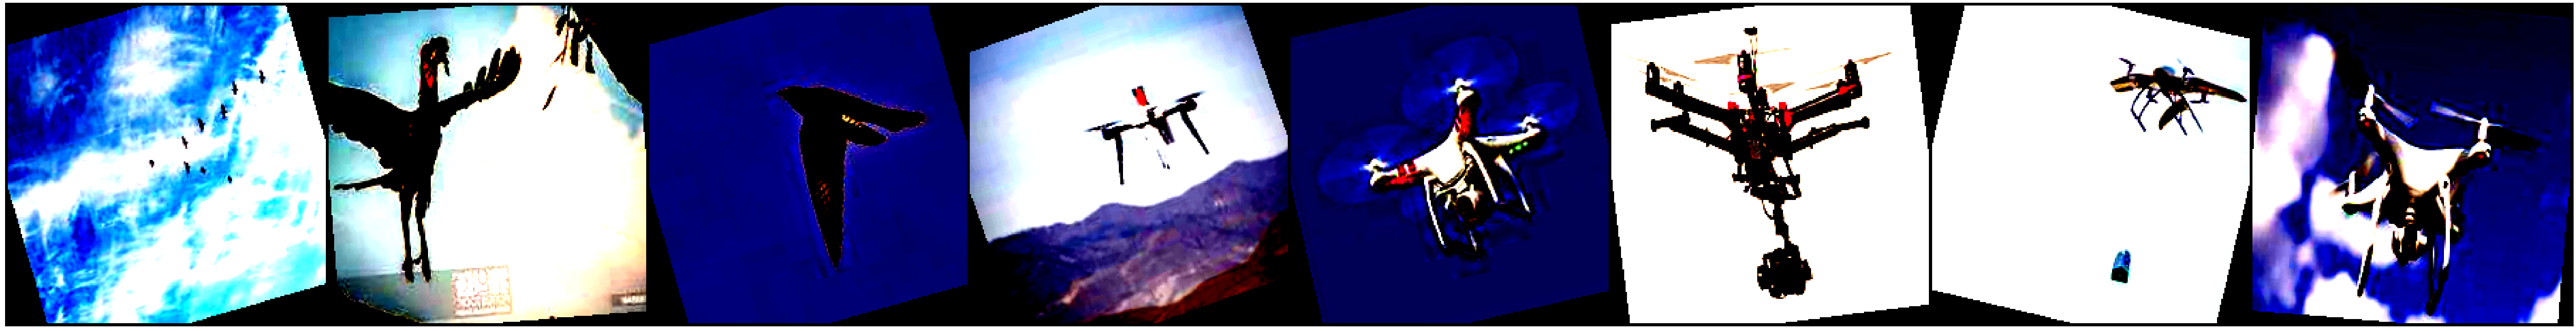

           [tensor(0)]            [tensor(0)]            [tensor(0)]            [tensor(1)]            [tensor(2)]            [tensor(1)]            [tensor(3)]            [tensor(3)]            [tensor(0)]            [tensor(2)]
time: 1min 37s


In [23]:
import numpy as np
image, label = next(iter(train_loader))
show(image,label)

Load model
---

### Mobilenet_V2

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.6.0', MODEL, pretrained=True)
model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 11.4 s


#### Freeze and modify Classification layer

In [25]:
for param in model.parameters():
    param.requires_grad = False    

n_inputs = model.classifier[1].in_features

model.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),
                            torch.nn.Linear(n_inputs, 512),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(0.2),
                            torch.nn.Linear(512, 4),                            
                            torch.nn.LogSoftmax(dim=1))

time: 11 ms


In [26]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 9.46 ms


In [27]:
# Print Summary
summary(model, input_size=(INPUT_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### Define loss function and optimizer

In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    nesterov=True) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.1,
    patience=1,
    verbose=False, 
    threshold=0.000001,
    threshold_mode='abs',
    cooldown=0, 
    min_lr=1e-8,
    eps=1e-08
)

time: 5.65 ms


## Train Model

In [29]:
from torch.autograd import Variable
from tqdm import tqdm

def train_model(model, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    early_stopping = EarlyStoppingOnAcc(patience=patience)
    
    for epoch in tqdm(range(1, n_epochs + 1)):
        for param_group in optimizer.param_groups:
          lr = param_group["lr"]
          print(f'\n **** learning rate: {lr}')
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for inputs, target in train_loader:
            inputs, target = inputs.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            
            # loss = Variable(loss, requires_grad = True)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        correct = 0
        total = 0
        accuracy = 0
        for inputs, target in val_loader:
            inputs, target = inputs.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        valid_accuracy = 100 * correct / total

        epoch_len = len(str(n_epochs))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'\tvalid_loss: {valid_loss:.5f}' +
                     f'\tvalid_accuracy: {valid_accuracy:.2f}')
        
        print(print_msg)

        # Tensorboard logging
        '''tb.add_scalar('Loss - Train loss',
                            train_loss / len(train_loader),
                            epoch * len(train_loader))
            
        tb.add_scalar('Loss - Val',
                        valid_loss/len(val_loader),
                        epoch * len(val_loader))
        
        tb.add_scalar('Accuracy - Val',
                            valid_accuracy/len(val_loader),
                            epoch * len(val_loader))'''
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        valid_accuracy = round(valid_accuracy, 2)
        scheduler.step(valid_accuracy)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        model_path = 'checkpoint.pt' # f'jantahackathon_v13_{valid_accuracy}.pth'
        early_stopping(valid_accuracy, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            if early_stopping.best_score is not None:
              print(f'Best score: {early_stopping.best_score}')
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_path))

    return  model, avg_train_losses, avg_valid_losses

time: 75.7 ms


In [30]:
model, train_loss, valid_loss = train_model(model, PATIENCE, EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]


 **** learning rate: 0.01

[  1/200] train_loss: 0.79302 	valid_loss: 0.53368	valid_accuracy: 80.19
Validation score improved (-inf --> 80.19). Saving model!


  0%|          | 1/200 [1:59:59<397:57:41, 7199.30s/it]


 **** learning rate: 0.01

[  2/200] train_loss: 0.55774 	valid_loss: 0.49813	valid_accuracy: 81.08
Validation score improved (80.19 --> 81.08). Saving model!


  1%|          | 2/200 [2:04:06<281:14:57, 5113.62s/it]


 **** learning rate: 0.01

[  3/200] train_loss: 0.53462 	valid_loss: 0.48259	valid_accuracy: 81.30
Validation score improved (81.08 --> 81.3). Saving model!


  2%|▏         | 3/200 [2:08:14<199:56:54, 3653.88s/it]


 **** learning rate: 0.01

[  4/200] train_loss: 0.51043 	valid_loss: 0.47631	valid_accuracy: 81.55
Validation score improved (81.3 --> 81.55). Saving model!


  2%|▏         | 4/200 [2:12:22<143:18:53, 2632.31s/it]


 **** learning rate: 0.01


  2%|▎         | 5/200 [2:16:31<103:50:57, 1917.22s/it]


[  5/200] train_loss: 0.50205 	valid_loss: 0.48142	valid_accuracy: 81.10
EarlyStopping counter: 1 out of 10

 **** learning rate: 0.01

[  6/200] train_loss: 0.49203 	valid_loss: 0.46363	valid_accuracy: 82.44
Validation score improved (81.55 --> 82.44). Saving model!


  3%|▎         | 6/200 [2:20:39<76:20:16, 1416.58s/it] 


 **** learning rate: 0.01


  4%|▎         | 7/200 [2:24:47<57:09:04, 1066.03s/it]


[  7/200] train_loss: 0.48799 	valid_loss: 0.45458	valid_accuracy: 82.34
EarlyStopping counter: 1 out of 10

 **** learning rate: 0.01


  4%|▍         | 8/200 [2:28:56<43:46:41, 820.84s/it] 


[  8/200] train_loss: 0.48570 	valid_loss: 0.45727	valid_accuracy: 81.80
EarlyStopping counter: 2 out of 10

 **** learning rate: 0.001


  4%|▍         | 9/200 [2:33:03<34:25:00, 648.69s/it]


[  9/200] train_loss: 0.47297 	valid_loss: 0.44463	valid_accuracy: 81.92
EarlyStopping counter: 3 out of 10

 **** learning rate: 0.001

[ 10/200] train_loss: 0.47056 	valid_loss: 0.43154	valid_accuracy: 82.49
Validation score improved (82.44 --> 82.49). Saving model!


  5%|▌         | 10/200 [2:37:11<27:53:43, 528.55s/it]


 **** learning rate: 0.001

[ 11/200] train_loss: 0.46479 	valid_loss: 0.43687	valid_accuracy: 82.86
Validation score improved (82.49 --> 82.86). Saving model!


  6%|▌         | 11/200 [2:41:19<23:18:55, 444.10s/it]


 **** learning rate: 0.001

[ 12/200] train_loss: 0.46105 	valid_loss: 0.43295	valid_accuracy: 82.92
Validation score improved (82.86 --> 82.92). Saving model!


  6%|▌         | 12/200 [2:45:27<20:07:56, 385.51s/it]


 **** learning rate: 0.001


  6%|▋         | 13/200 [2:49:34<17:51:43, 343.87s/it]


[ 13/200] train_loss: 0.47092 	valid_loss: 0.43314	valid_accuracy: 82.92
EarlyStopping counter: 1 out of 10

 **** learning rate: 0.001


  7%|▋         | 14/200 [2:53:42<16:16:34, 315.02s/it]


[ 14/200] train_loss: 0.46046 	valid_loss: 0.46066	valid_accuracy: 81.75
EarlyStopping counter: 2 out of 10

 **** learning rate: 0.0001

[ 15/200] train_loss: 0.46114 	valid_loss: 0.43872	valid_accuracy: 83.02
Validation score improved (82.92 --> 83.02). Saving model!


  8%|▊         | 15/200 [2:57:51<15:10:03, 295.15s/it]


 **** learning rate: 0.0001


  8%|▊         | 16/200 [3:01:58<14:21:06, 280.80s/it]


[ 16/200] train_loss: 0.46046 	valid_loss: 0.43868	valid_accuracy: 82.49
EarlyStopping counter: 1 out of 10

 **** learning rate: 0.0001


  8%|▊         | 17/200 [3:06:06<13:46:24, 270.95s/it]


[ 17/200] train_loss: 0.46025 	valid_loss: 0.45452	valid_accuracy: 82.53
EarlyStopping counter: 2 out of 10

 **** learning rate: 1e-05


  9%|▉         | 18/200 [3:10:13<13:20:29, 263.90s/it]


[ 18/200] train_loss: 0.45668 	valid_loss: 0.44057	valid_accuracy: 82.86
EarlyStopping counter: 3 out of 10

 **** learning rate: 1e-05


 10%|▉         | 19/200 [3:14:21<13:01:50, 259.18s/it]


[ 19/200] train_loss: 0.46648 	valid_loss: 0.44086	valid_accuracy: 82.63
EarlyStopping counter: 4 out of 10

 **** learning rate: 1.0000000000000002e-06


 10%|█         | 20/200 [3:18:29<12:47:33, 255.86s/it]


[ 20/200] train_loss: 0.46327 	valid_loss: 0.44467	valid_accuracy: 82.41
EarlyStopping counter: 5 out of 10

 **** learning rate: 1.0000000000000002e-06


 10%|█         | 21/200 [3:22:37<12:35:50, 253.35s/it]


[ 21/200] train_loss: 0.45871 	valid_loss: 0.43671	valid_accuracy: 82.61
EarlyStopping counter: 6 out of 10

 **** learning rate: 1.0000000000000002e-07


 11%|█         | 22/200 [3:26:47<12:28:28, 252.29s/it]


[ 22/200] train_loss: 0.45661 	valid_loss: 0.44815	valid_accuracy: 82.45
EarlyStopping counter: 7 out of 10

 **** learning rate: 1.0000000000000002e-07


 12%|█▏        | 23/200 [3:30:56<12:21:37, 251.40s/it]


[ 23/200] train_loss: 0.46297 	valid_loss: 0.45314	valid_accuracy: 82.28
EarlyStopping counter: 8 out of 10

 **** learning rate: 1.0000000000000004e-08


 12%|█▏        | 24/200 [3:35:06<12:15:43, 250.82s/it]


[ 24/200] train_loss: 0.46319 	valid_loss: 0.44900	valid_accuracy: 82.89
EarlyStopping counter: 9 out of 10

 **** learning rate: 1.0000000000000004e-08

[ 25/200] train_loss: 0.45938 	valid_loss: 0.43862	valid_accuracy: 82.05
EarlyStopping counter: 10 out of 10
Early stopping
Best score: 83.02
time: 3h 39min 17s


## Visualizing the loss

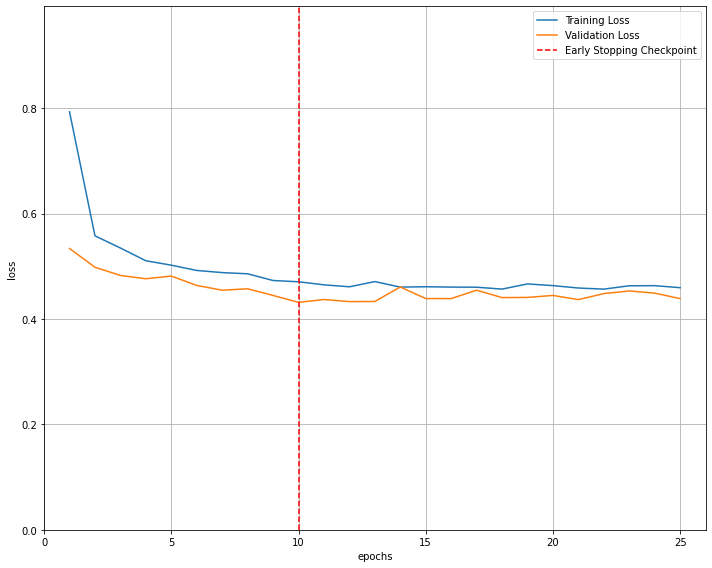

time: 435 ms


In [31]:
# visualize the loss as the network trained
displayloss(train_loss, valid_loss)

## Load the saved model

In [32]:
loadedModel = torch.jit.load(MODEL_FILE)
print(loadedModel)

RecursiveScriptModule(
  original_name=MobileNetV2
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ConvBNReLU
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU6)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ConvBNReLU
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU6)
        )
        (1): RecursiveScriptModule(original_name=Conv2d)
        (2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
    )
    (2): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
     

In [ ]:
# model=torch.load(MODEL_FILE)
# model.eval()

In [33]:
from torchvision import transforms
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

time: 2.08 ms


## Validate Model

Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 0 and predicted : 1
Misclassified Image :
	Actual Label : 1 and predicted : 3
Misclassified Image :
	Actual Label : 2 and predicted : 0
Misclassified Image :
	Actual Label : 2 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 1
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 2 and predicted : 0
Misclassified Image :
	Actual Label : 1 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified Image :
	Actual Label : 2 and predicted : 0
Misclassified Image :
	Actual Label : 2 and predicted : 0
Misclassified Image :
	Actual Label : 2 and predicted : 0
Misclassified Image :
	Actual Label : 3 and predicted : 0
Misclassified 

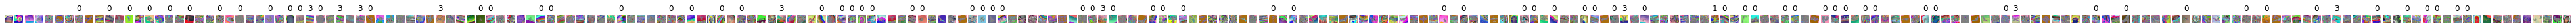

time: 12.5 s


In [34]:

from matplotlib import pyplot as plt

to_pil = torchvision.transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(70,70))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    #print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    if res:
        sub.set_title(index)
    else:
        print('Misclassified Image :\n\tActual Label : {} and predicted : {}'.format(int(labels[ii]),index))
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Test model

In [ ]:
from matplotlib import pyplot as plt
predClass = []

#for _ in np.arange(float(len(testDs))/8.0+1): 
data = iter(val_loader)
#for v in np.arange(float(len(testDs))/8.0+1): 
from IPython.core.debugger import set_trace
res = True
row = 1
while res:
    try:
        images = data.next()
        res = False if len(images)==0 else True
    except Exception as e:
        print(str(e))
        break
    to_pil = torchvision.transforms.ToPILImage()

    print(f'Row : {row}')
    row = row + 1
    #fig=plt.figure(figsize=(30,30))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        index = predict_image(image)
        predClass.append(index)
        #sub = fig.add_subplot(1, len(images), ii+1)
        #sub.set_title(index)
        #plt.axis('off')
        #plt.imshow(image)
    #plt.show()
    #set_trace()

In [ ]:
print(len(np.array(predClass)))

## Setup in powershell

1. Start powershell in admin mode
2. Set execution policy 'Set-ExecutionPolicy Scope Process -ExecutionPolicy Bypass'
3.serverless plugin install --name serverless-python-requirements
4. npm run deploy
5. Grant permission to docker for file sharing


In [ ]:
train_loss.shape

In [ ]:
print(len(train_loss))

In [ ]:
train_loss[0]